# Facebook DETR 2D Object Detection

Modified from: https://github.com/facebookresearch/detr
Mean Average Precision (mAP) calculation from: https://github.com/Cartucho/mAP

In [1]:
!git clone https://github.com/JonathanJTang/mAP.git
import os
os.chdir('mAP')

Cloning into 'mAP'...
remote: Enumerating objects: 911, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 911 (delta 0), reused 2 (delta 0), pack-reused 908
Receiving objects: 100% (911/911), 14.71 MiB | 33.78 MiB/s, done.
Resolving deltas: 100% (321/321), done.


## Preliminaries (Unmodified)
**Below provided code is given by https://github.com/facebookresearch/detr**

This section contains the boilerplate necessary for the other sections. Run it first.

In [2]:
import math

from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import ipywidgets as widgets
from IPython.display import display, clear_output

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

In [3]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]


# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [4]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [5]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

# Detection - using a pre-trained model from TorchHub (Unmodified)

**Below provided code is given by https://github.com/facebookresearch/detr**
In this section, we show-case how to load a model from hub, run it on a custom image, and print the result.
Here we load the simplest model (DETR-R50) for fast inference. You can swap it with any other model from the model zoo.

In [6]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
#model = torch.hub.load('facebookresearch/detr', 'detr_resnet101_dc5', pretrained=True)
model.eval();

Downloading: "https://github.com/facebookresearch/detr/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth


In [7]:
# For visualizing individual images
def preprocess_img(img):
  # mean-std normalize the input image (batch-size: 1)
  img = transform(im).unsqueeze(0)

  # propagate through the model
  outputs = model(img)

  # keep only predictions with 0.7+ confidence
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > 0.9

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

  print(bboxes_scaled)
  print(probas[keep])

  plot_results(im, probas[keep], bboxes_scaled)

# Retrieve images from the drive 

**Drive folder:** https://drive.google.com/drive/folders/1FMVDmNVoln3WqyhUdBDyf9_XoFSAUNai?usp=sharing

These are images generated by the pix2pix and CycleGAN models along with the original models

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Run DETR on images processed by our GANs

import os
import shutil
from tqdm import tqdm
from torchvision.datasets import ImageFolder
from PIL import Image

coco_class_to_kitti_class_name = ['N/A', 'person', 'cyclist', 'car', 'cyclist', 'N/A', 'truck', 'tram', 'truck']
# Unable to distinguish between "Pedestrian," "Person_sitting"

# car, bus, truck, person, motorcycle
coco_class_to_dawn_class_name = ['N/A', 'person', 'motorcycle', 'car', 'motorcycle', 'N/A', 'bus', 'truck', 'truck']

def rename_files_for_metric(orig_directory_path, target_directory_path):
    """Move images in orig_directory_path generated by our GAN into
    target_directory_path, renaming them to their original filename for
    comparing against ground truth.

    target_directory_path must be a directory that already exists.
    """
    for filename in tqdm(os.listdir(orig_directory_path)):
        root, extension = os.path.splitext(filename)
        if root.endswith("_fake"):
            # This is an image generated by our GAN; remove the filename's "_fake" ending
            #os.rename(os.path.join(orig_directory_path, filename),
            #          os.path.join(target_directory_path, root[:root.rfind("_")] + extension))
            shutil.copyfile(os.path.join(orig_directory_path, filename),
                      os.path.join(target_directory_path, root[:root.rfind("_")] + extension))

def run_detection_on_images(image_directory_path, detection_results_path,
                            confidence_threshold = 0.8):
    #image_dataset = ImageFolder(root=image_directory_path)
    #dataset_loader = torch.utils.data.DataLoader(image_dataset, num_workers=4)
    for filename in tqdm(os.listdir(image_directory_path)):
        im = Image.open(os.path.join(image_directory_path, filename))
        # mean-std normalize the input image (batch-size: 1)
        img = transform(im).unsqueeze(0)
        # propagate through the model
        outputs = model(img)

        # keep only predictions with confidence > threshold
        probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
        keep = probas.max(-1).values > confidence_threshold

        # convert boxes from [0; 1] to image scales
        bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

        filename = os.path.basename(os.path.normpath(image_directory_path))
        root, extension = os.path.splitext(filename)
        with open(os.path.join(detection_results_path, f"{root}.txt"), "w") as results_file:
            for p, (xmin, ymin, xmax, ymax) in zip(probas[keep], bboxes_scaled.tolist()):
                cl = p.argmax()
                if 1 <= cl and cl <= 8 and cl != 5:  # Only look at KITTI-related classes
                    # Format: <class_name> <confidence> <left> <top> <right> <bottom>
                    results_file.write(f"{coco_class_to_dawn_class_name[cl]} {p[cl]} {xmin} {ymin} {xmax} {ymax}\n")
                    #print(f"Wrote string of: {CLASSES[cl]} {p[cl]} {xmin} {ymin} {xmax} {ymax}")

for dir_path in ["generated_images", "detection_results"]:
    if not os.path.isdir(dir_path):
        os.mkdir(dir_path)

image_directory_path = "./generated_images"
detection_results_path = "./detection_results"
confidence_threshold = 0.8
#rename_files_for_metric("/content/drive/MyDrive/CSC413 Group 61/images", image_directory_path)
run_detection_on_images(image_directory_path, detection_results_path, confidence_threshold)


 20%|█▉        | 202/1026 [09:11<36:56,  2.69s/it]

In [ ]:
im = Image.open('/content/drive/MyDrive/CSC413 Group 61/results//test_latest/images/dusttornado-001_fake.png')

In [ ]:
im = Image.open('/content/drive/MyDrive/CSC413 Group 61/results/derained/test_latest/images/foggy-011_real.png')

In [ ]:
im = Image.open('/content/drive/MyDrive/CSC413 Group 61/results/derained/test_latest/images/snow_storm-062_real.png')

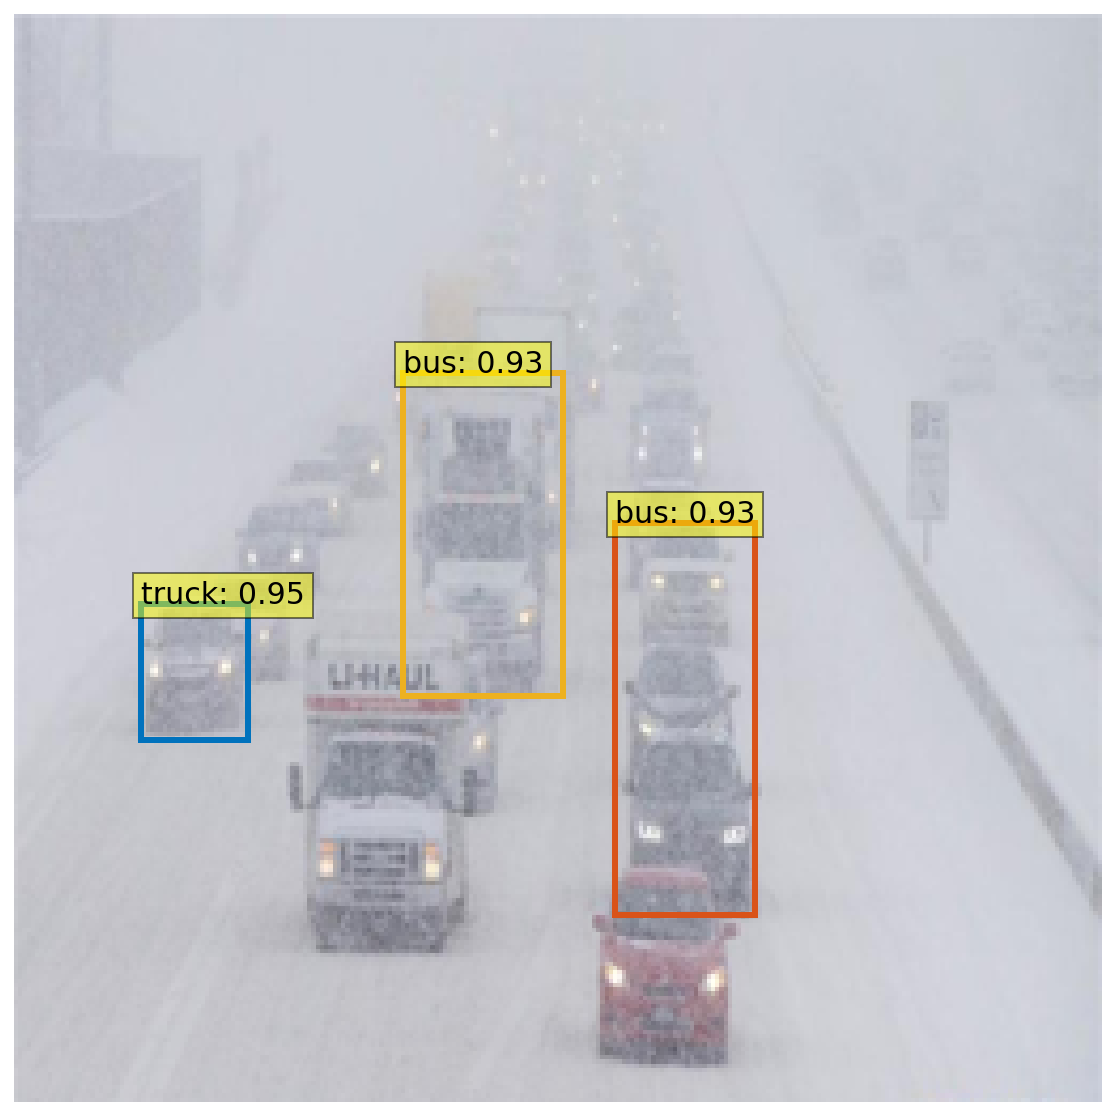

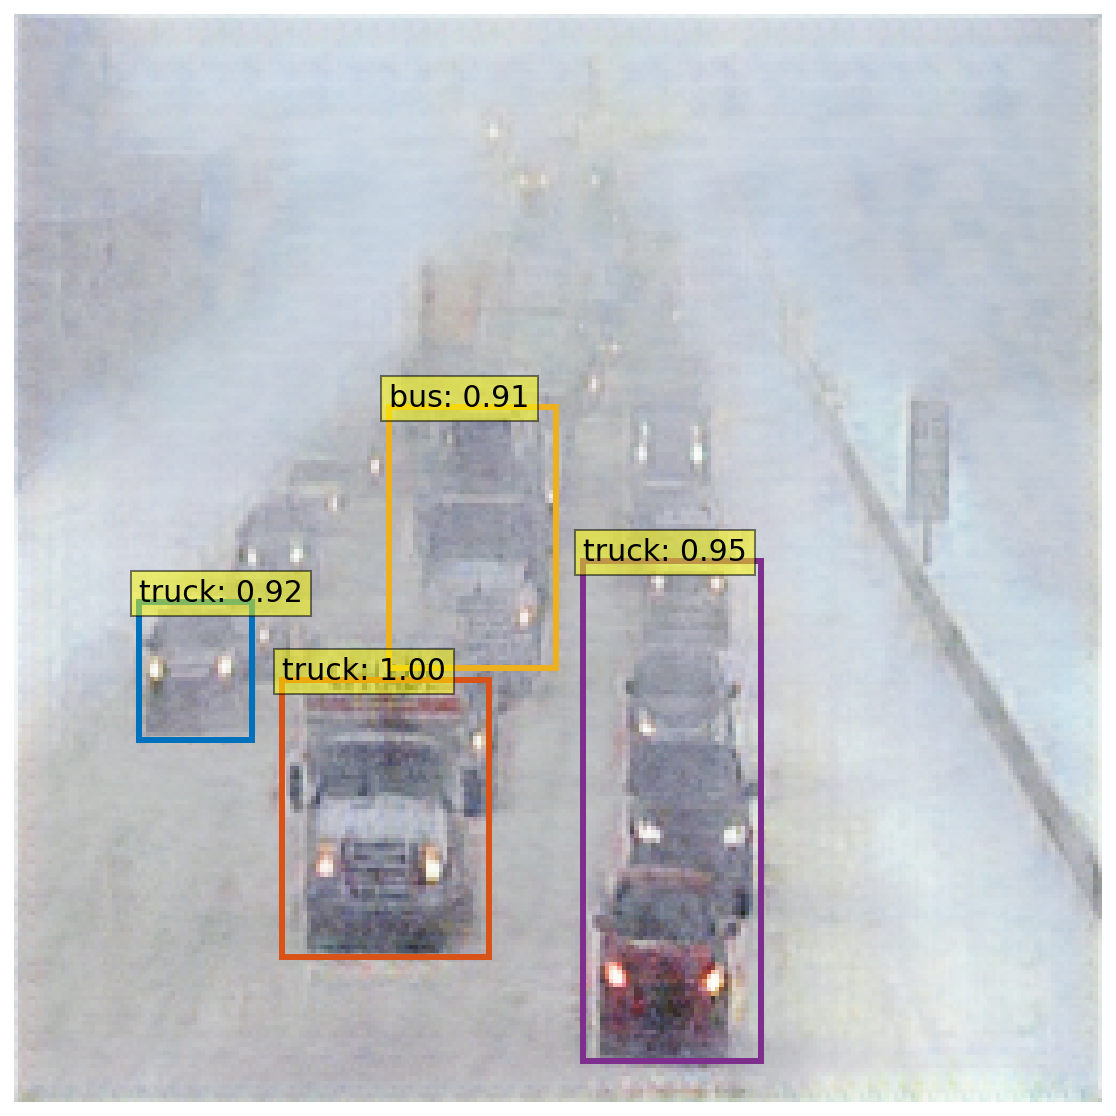

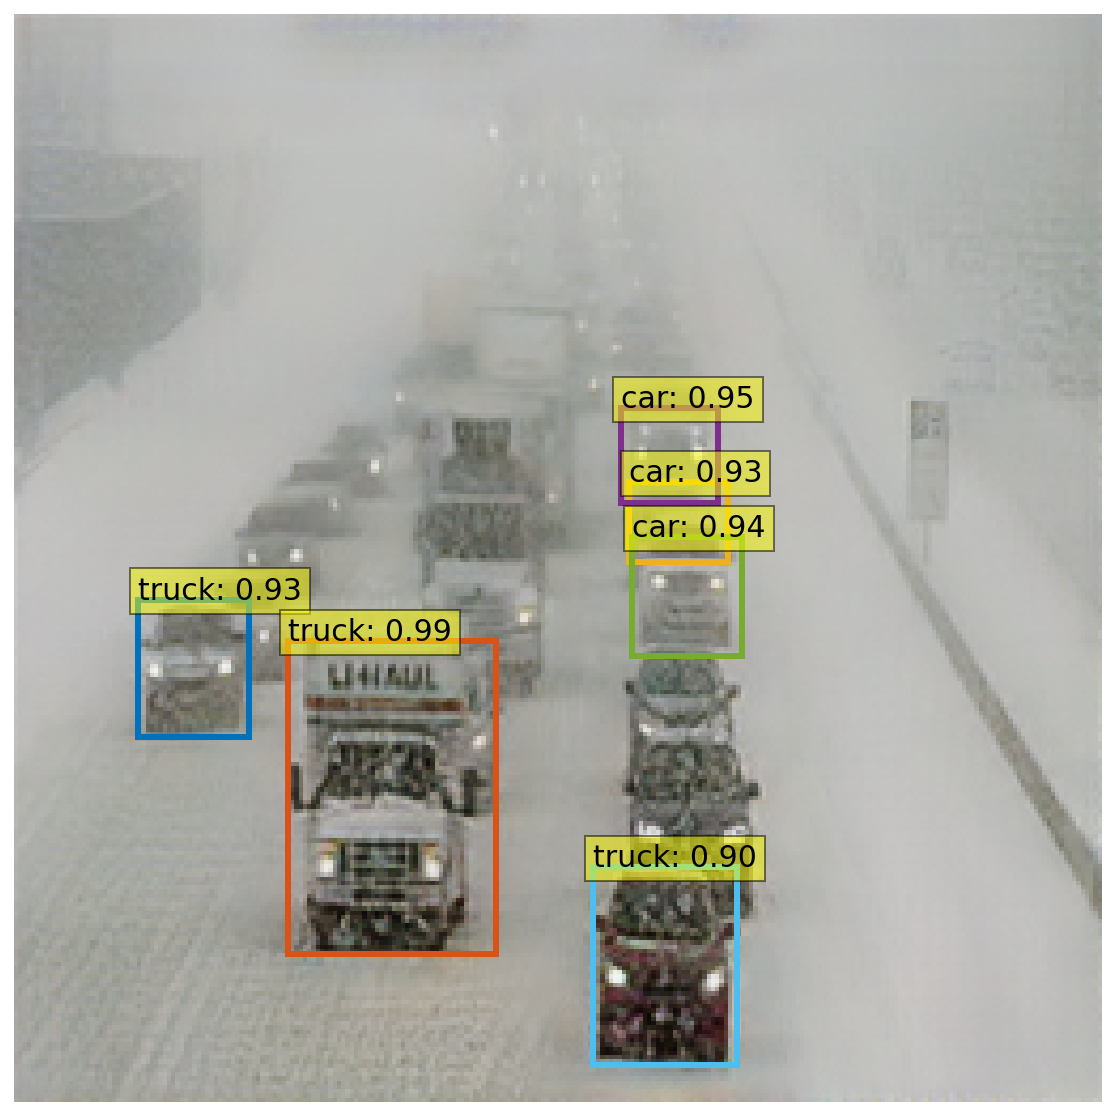

In [ ]:
# Can use bounding boxes to calculate overall performance improvement, using mAP metric
im = Image.open('/content/drive/MyDrive/CSC413 Group 61/CycleGAN_Results/snow_storm-016_real.png')
preprocess_img(im)
im = Image.open('/content/drive/MyDrive/CSC413 Group 61/results/derained/test_latest/images/snow_storm-016_fake.png')
preprocess_img(im)
im = Image.open('/content/drive/MyDrive/CSC413 Group 61/CycleGAN_Results/snow_storm-016_fake.png')
preprocess_img(im)

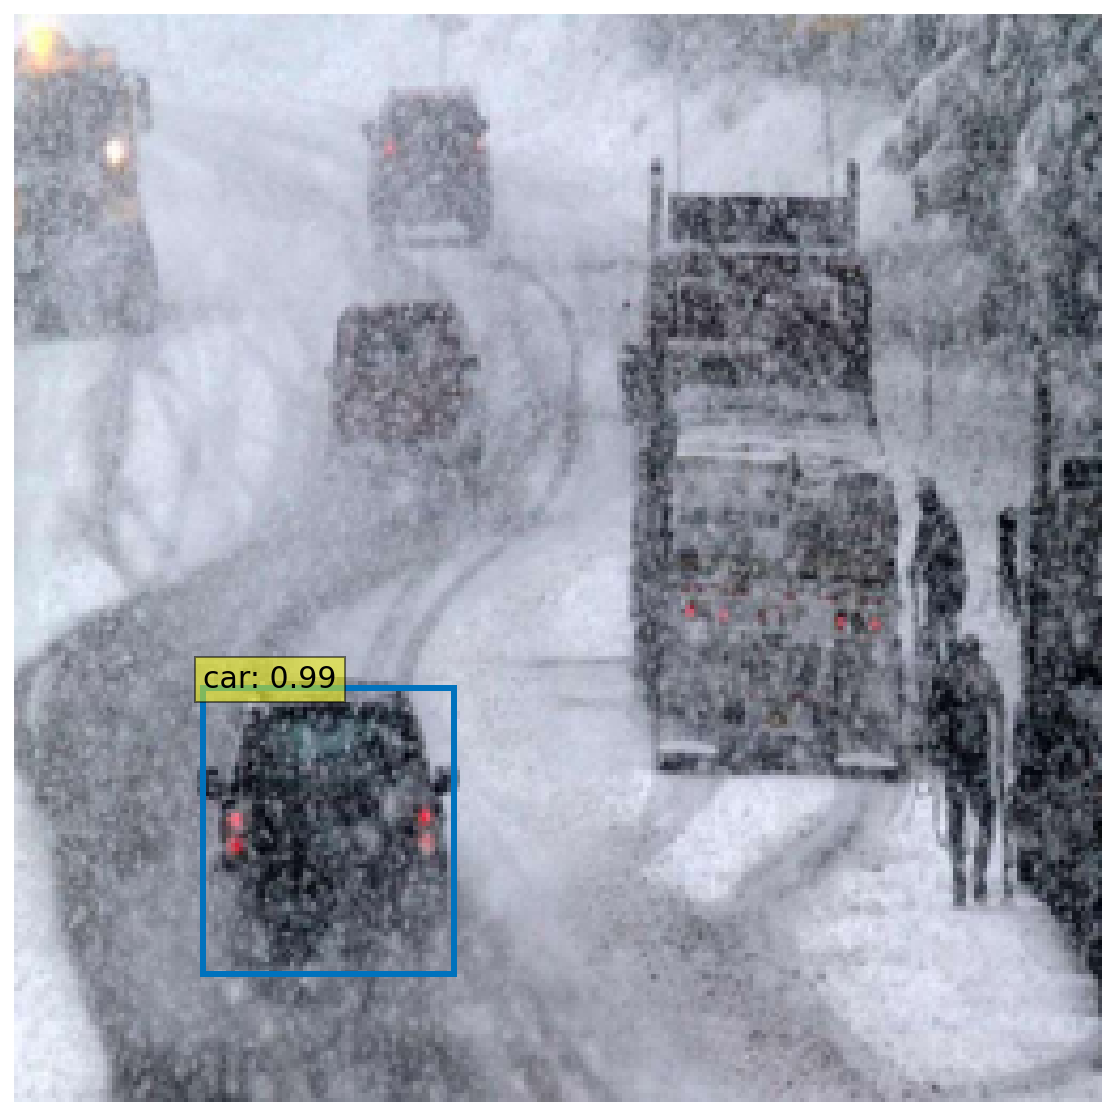

In [ ]:
preprocess_img(im)

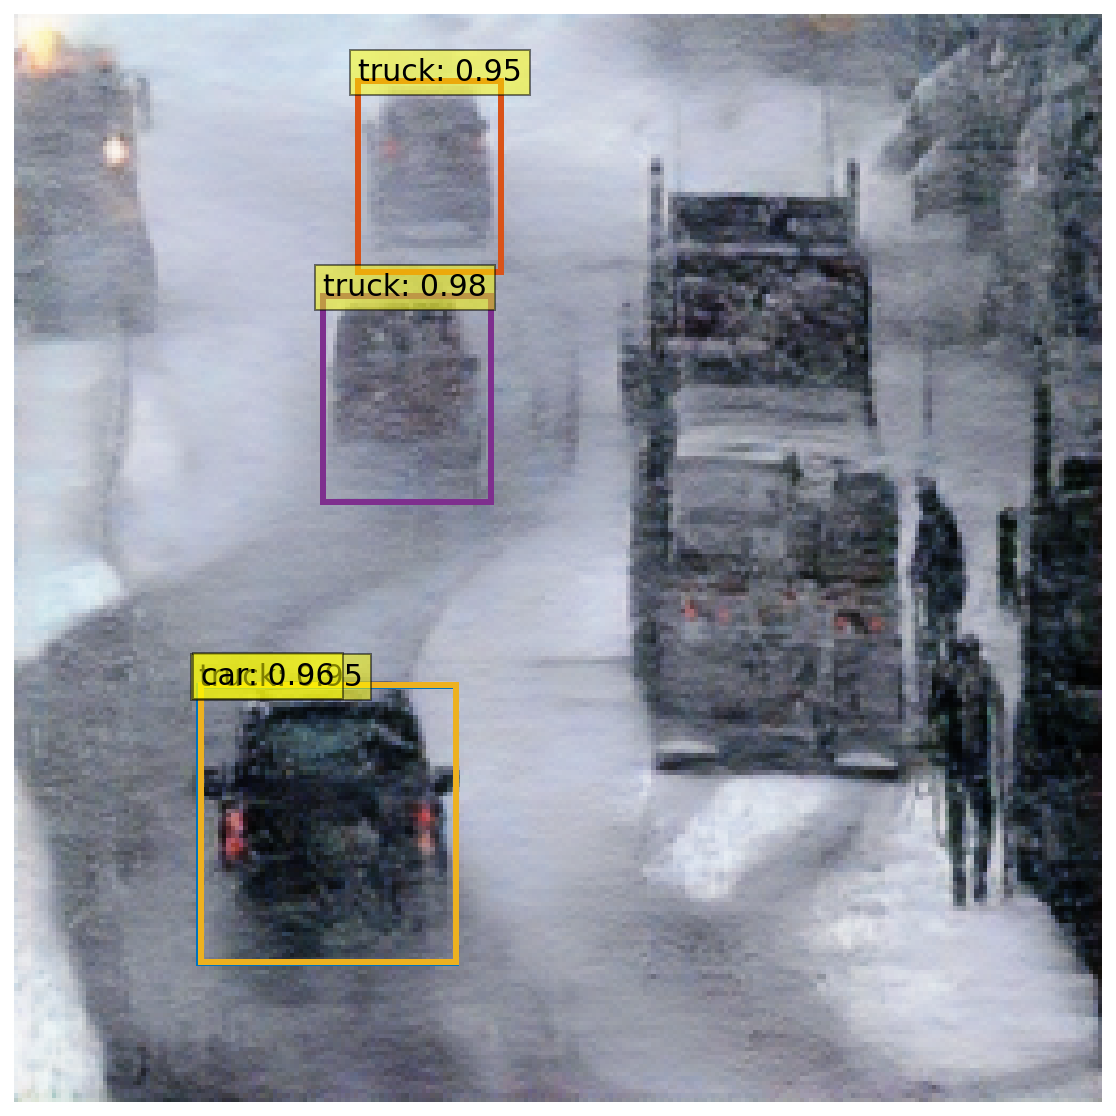

In [ ]:
im = Image.open('/content/drive/MyDrive/CSC413 Group 61/results/derained/test_latest/images/snow_storm-062_fake.png')
preprocess_img(im)